In [1]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from scipy.signal import hilbert, butter, lfilter
from scipy.stats import rankdata

## Reading In *Gravity* Audio Files

**Film Clip 1**

In [2]:
grav1_signal, grav1_samplerate = sf.read('/scratch/gpfs/mayaar/GravityECoG/sourcedata/grav1.wav')

In [3]:
grav1_signal.shape

(7204224,)

In [4]:
grav1_samplerate

16000

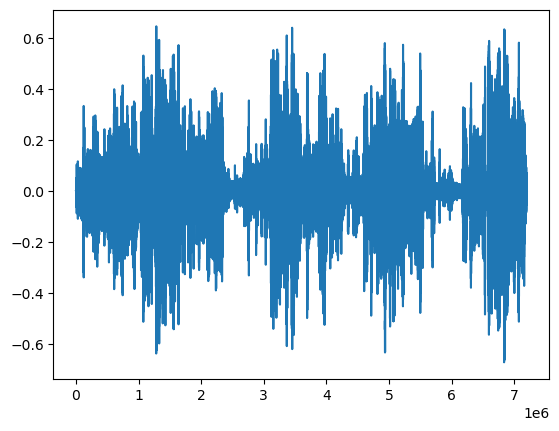

In [5]:
plt.plot(grav1_signal);

**Film Clip 2**

In [6]:
grav2_signal, grav2_samplerate = sf.read('/scratch/gpfs/mayaar/GravityECoG/sourcedata/grav2.wav')

In [7]:
grav2_signal.shape

(7206912,)

In [8]:
grav2_samplerate

16000

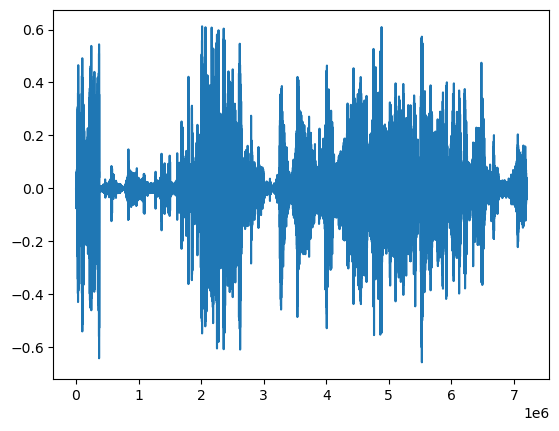

In [9]:
plt.plot(grav2_signal);

## Bandpass Filtering the Audio (200 - 5000 Hz)

Adapted from https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

In [10]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [11]:
lowcut = 200.0
highcut = 5000.0

grav1_bandpass = butter_bandpass_filter(grav1_signal, lowcut, highcut, grav1_samplerate, order=6)
grav2_bandpass = butter_bandpass_filter(grav2_signal, lowcut, highcut, grav2_samplerate, order=6)

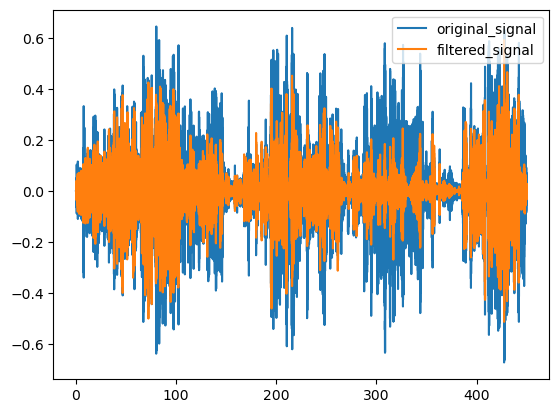

In [12]:
# Film Clip 1
t = np.arange(grav1_signal.shape[0]) / grav1_samplerate
plt.plot(t, grav1_signal, label='original_signal')
plt.plot(t, grav1_bandpass, label='filtered_signal');
plt.legend(loc="upper right")

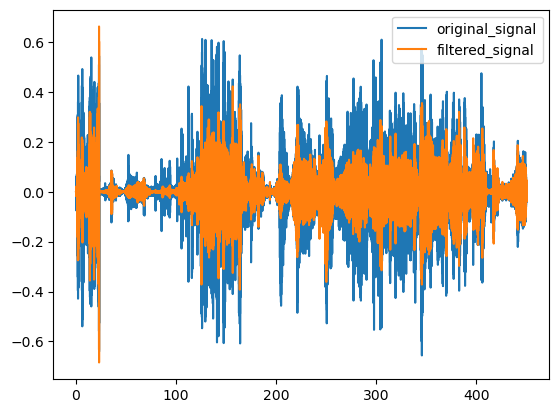

In [13]:
# Film Clip 2
t2 = np.arange(grav2_signal.shape[0]) / grav2_samplerate
plt.plot(t2, grav2_signal, label='original_signal')
plt.plot(t2, grav2_bandpass, label='filtered_signal');
plt.legend(loc="upper right")

## Extracting the Audio Envelope via a Hilbert Transform

In [14]:
def extract_envelope(signal, samplerate):
    t = np.arange(signal.shape[0]) / samplerate
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    return t, amplitude_envelope

In [15]:
grav1_t, grav1_envelope = extract_envelope(grav1_bandpass, grav1_samplerate)

In [16]:
grav2_t, grav2_envelope = extract_envelope(grav2_bandpass, grav2_samplerate)

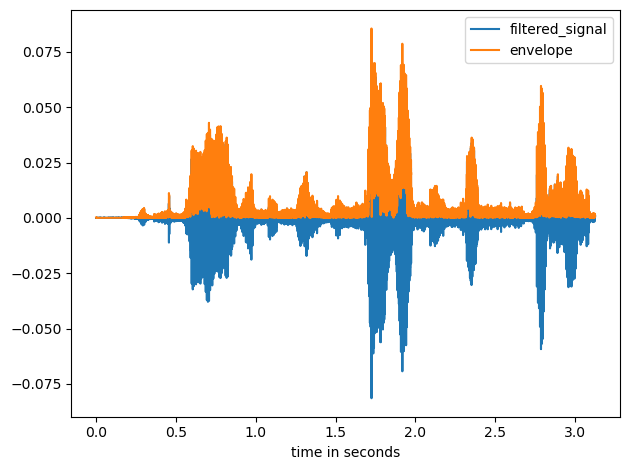

In [17]:
# Film Clip 1
plt.plot(grav1_t[:50000], grav1_bandpass[:50000], label='filtered_signal')
plt.plot(grav1_t[:50000], grav1_envelope[:50000], label='envelope')
plt.xlabel("time in seconds")
plt.legend(loc='upper right')
plt.tight_layout()

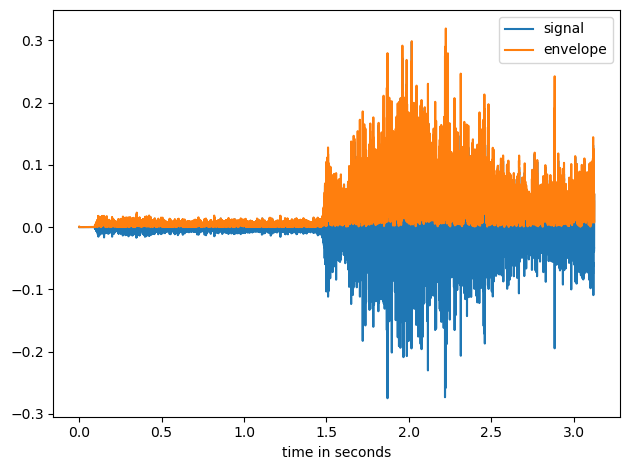

In [18]:
# Film Clip 2
plt.plot(grav2_t[:50000], grav2_bandpass[:50000], label='signal')
plt.plot(grav2_t[:50000], grav2_envelope[:50000], label='envelope')
plt.xlabel("time in seconds")
plt.legend(loc='upper right')
plt.tight_layout()

## Downsampling the Audio

In [19]:
downsampled_rate = 512 #Hz

def downsample_audio(amplitude_envelope, original_rate):
    amplitude_envelope_downsampled = librosa.resample(amplitude_envelope, orig_sr=original_rate, target_sr=downsampled_rate)
    t_downsampled = np.arange(amplitude_envelope_downsampled.shape[0]) / downsampled_rate
    return t_downsampled, amplitude_envelope_downsampled

In [20]:
grav1_t_downsampled, grav1_downsampled_envelope = downsample_audio(grav1_envelope, grav1_samplerate)

In [21]:
grav2_t_downsampled, grav2_downsampled_envelope = downsample_audio(grav2_envelope, grav2_samplerate)

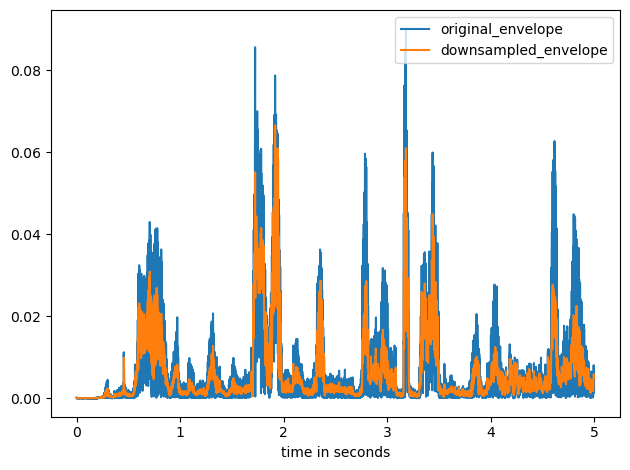

In [22]:
# Film Clip 1
plt.plot(grav1_t[:5*grav1_samplerate], grav1_envelope[:5*grav1_samplerate], label='original_envelope')
plt.plot(grav1_t_downsampled[:5*downsampled_rate], grav1_downsampled_envelope[:5*downsampled_rate], label='downsampled_envelope')
plt.xlabel("time in seconds")
plt.legend(loc='upper right')
plt.tight_layout()

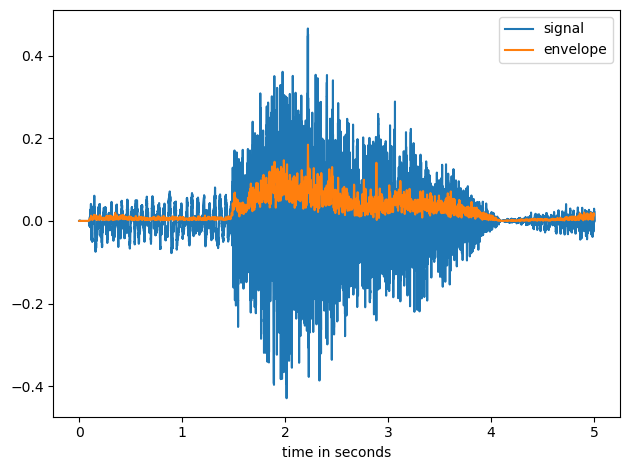

In [23]:
# Film Clip 2
plt.plot(grav2_t[:5*grav2_samplerate], grav2_signal[:5*grav2_samplerate], label='signal')
plt.plot(grav2_t_downsampled[:5*downsampled_rate], grav2_downsampled_envelope[:5*downsampled_rate], label='envelope')
plt.xlabel("time in seconds")
plt.legend(loc='upper right')
plt.tight_layout()

In [ ]:
np.save("grav1preprocessedaudio.npy", grav1_downsampled_envelope)

In [ ]:
np.save("grav2preprocessedaudio.npy", grav2_downsampled_envelope)

## Tie-Ranking the Audio

In [24]:
tie_ranked_grav1 = rankdata(grav1_downsampled_envelope)
tie_ranked_grav2 = rankdata(grav2_downsampled_envelope)

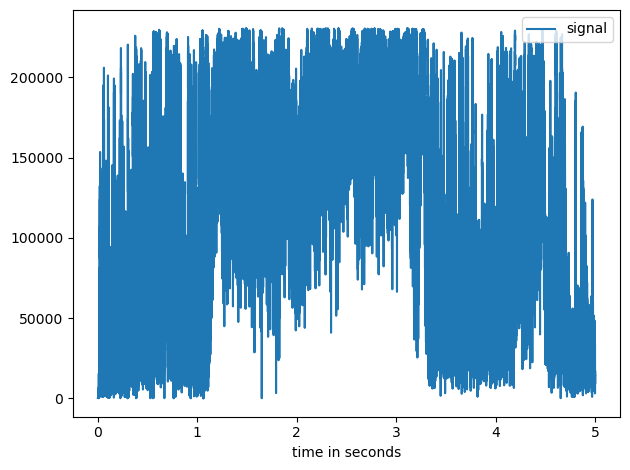

In [25]:
# Film Clip 1
plt.plot(grav1_t[:5*grav2_samplerate], tie_ranked_grav1[:5*grav2_samplerate], label='signal')
plt.xlabel("time in seconds")
plt.legend(loc='upper right')
plt.tight_layout()

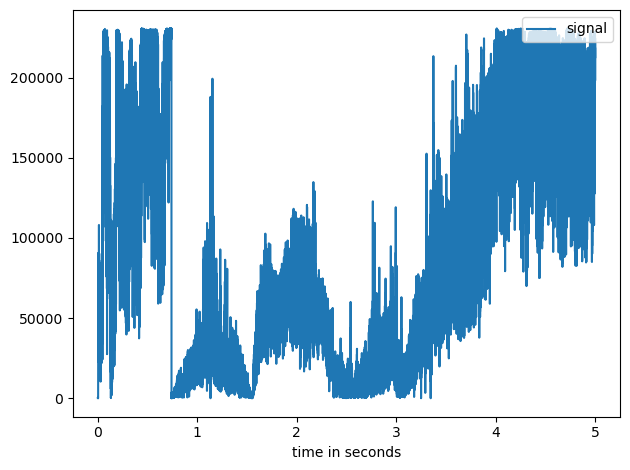

In [26]:
# Film Clip 2
plt.plot(grav2_t[:5*grav2_samplerate], tie_ranked_grav2[:5*grav2_samplerate], label='signal')
plt.xlabel("time in seconds")
plt.legend(loc='upper right')
plt.tight_layout()

# Iterated Amplitude Adjusted Fourier Transform
### (to obtain time series surrogates)

#### Note: this is just a demonstration of how to obtain surrogates via IAAFT.

In [7]:
# Array containing the IAAFT surrogates of `g1` such that each row of `g1s` is an individual surrogate time series
ns = 100 #1000
grav1_downsampled_envelope = np.load("grav1audio.npy", allow_pickle = True)
g1s = iaaft.surrogates(grav1_downsampled_envelope, ns=ns)

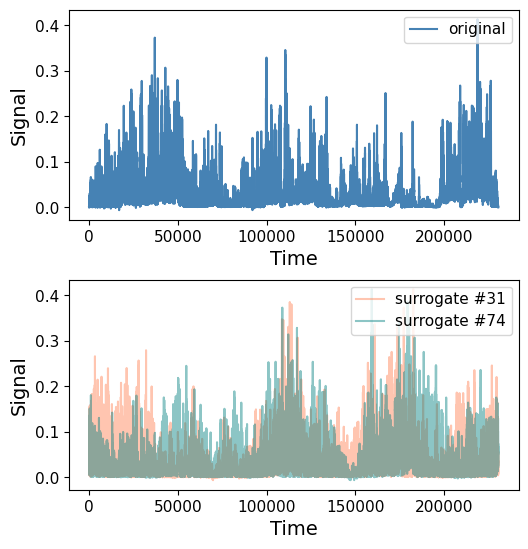

In [8]:
# Plot the results
AXLABFS, TIKLABFS = 14, 11
fig = plt.figure(figsize=[12., 6.])
ax1 = fig.add_axes([0.10, 0.55, 0.375, 0.35])
ax2 = fig.add_axes([0.10, 0.10, 0.375, 0.35])

# plot original time series
ax1.plot(grav1_downsampled_envelope, "steelblue", label="original")

# plot two random surrogate time series
idx = np.random.randint(ns, size=2)
clrs = ["coral", "teal", "goldenrod"]
for j, i in enumerate(idx):
    ax2.plot(test[i], c=clrs[j], label="surrogate #%d" % i, alpha=0.45)

# beautification
for ax in fig.axes:
    leg = ax.legend(loc="upper right")
    for txt in leg.get_texts():
        txt.set_size(TIKLABFS)
    ax.tick_params(labelsize=TIKLABFS)
for ax in [ax1, ax2]:
    ax.set_ylabel("Signal", fontsize=AXLABFS)
    ax.set_xlabel("Time", fontsize=AXLABFS)

plt.show()